# <center>**新闻分类**</center>
<hr></hr>  

### <center>**实战实验报告**</center>
#### **<center>控制科学与工程学院&emsp;3200100259&emsp;沈骏一</center>**  
#### **<center>控制科学与工程学院&emsp;3200100259&emsp;朱语</center>**  
#### **<center>控制科学与工程学院&emsp;3200100259&emsp;宋孟炫</center>**  

# 一、BERT模型概述
BERT的全称为Bidirectional Encoder Representation from Transformers，是一个预训练的语言表征模型。它强调了不再像以往一样采用传统的单向语言模型或者把两个单向语言模型进行浅层拼接的方法进行预训练，而是采用新的masked language model（MLM），以致能生成深度的双向语言表征。  
BERT论文发表时提及在11个NLP（Natural Language Processing，自然语言处理）任务中获得了新的state-of-the-art的结果，令人目瞪口呆。   
而BERT利用MLM进行预训练并且采用深层的双向Transformer组件来构建整个模型，最终生成能融合左右上下文信息的深层双向语言表征。  
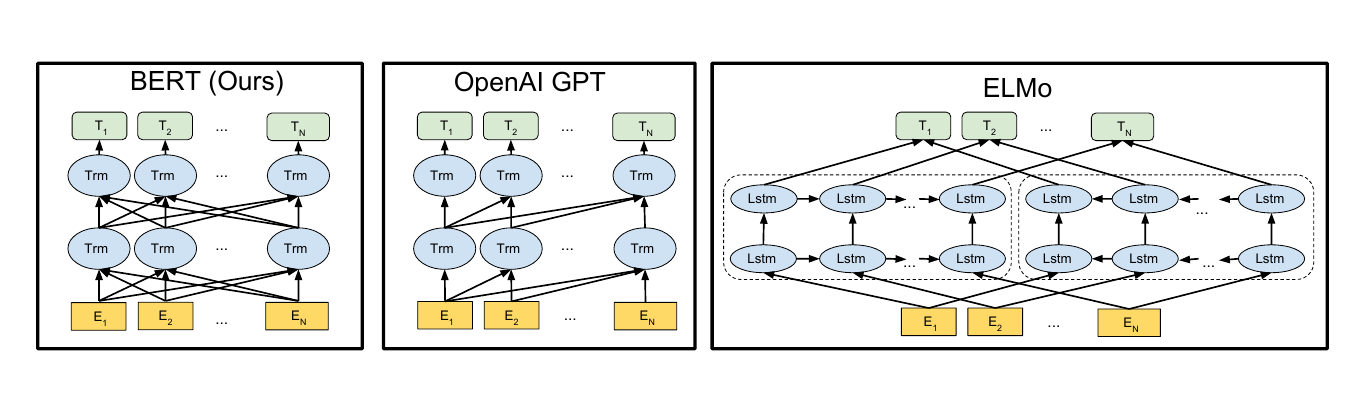

BERT的输入为每一个token对应的表征，实际上该表征是由三部分组成的，分别是对应的token，分割和位置 embeddings。   
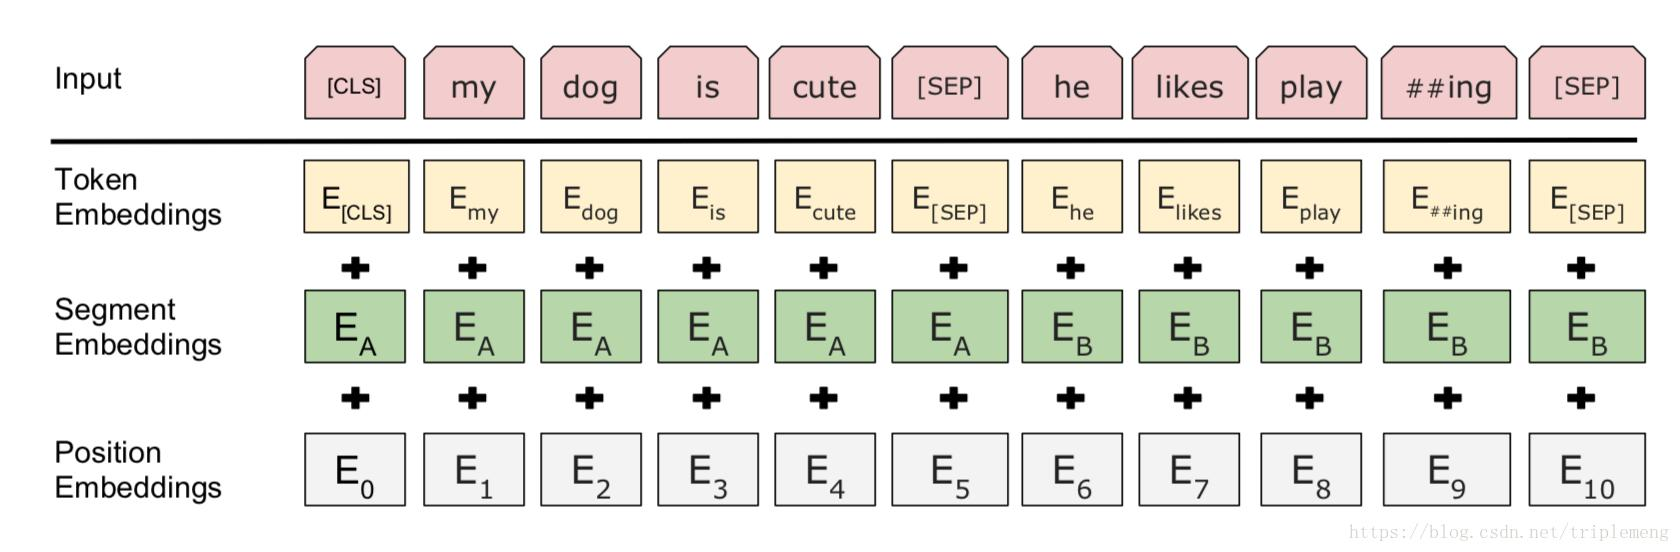  
Transformer的特点就是有多少个输入就有多少个对应的输出。

Whole Word Masking (wwm)，暂翻译为全词Mask或整词Mask，是谷歌在2019年5月31日发布的一项BERT的升级版本，主要更改了原预训练阶段的训练样本生成策略。 简单来说，原有基于WordPiece的分词方式会把一个完整的词切分成若干个子词，在生成训练样本时，这些被分开的子词会随机被mask。   
在全词Mask中，如果一个完整的词的部分WordPiece子词被mask，则同属该词的其他部分也会被mask，即全词Mask。

由于笔者水平限制，对于Bert模型还没有充分的理解。详情可参见论文  
`《Attention is all you need》`  
`《Pre-Training with Whole Word Masking for Chinese BERT》`

# 二、BERT主干网络搭建
首先，加载实验所需要的包：

In [4]:
import pandas as pd 
import numpy as np 
import json, time 
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertConfig, BertTokenizer, AdamW, get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')

在本次实验探究中，我们选择采用`BERT`模型完成新闻的分类工作   
在经过多次的试验后，我们选择了`HFL`实验室的`RBT3`模型进行新闻的推断工作  
其余模型的结果在之后模块中呈现

In [11]:
#从Transformer包中加载模型
model_name = 'hfl/rbt3'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at hfl/rbt3 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


采用测试句子查看BERT层的输入输出结构

In [15]:
sen = 'Transformers提供了NLP领域大量state-of-art的 预训练语言模型结构的模型和调用框架。'
inputs = tokenizer(sen, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(inputs)
print(tokens)
outputs = model(**inputs)
print(len(outputs))
print(outputs[0].shape, outputs[1].shape)

{'input_ids': tensor([[  101,   162, 10477,  8118, 12725,  8755,  2990,   897,   749,   156,
         10986,  7566,  1818,  1920,  7030, 10223,   118,  8205,   118,  9143,
          4638,  7564,  6378,  5298,  6427,  6241,  3563,  1798,  5310,  3354,
          4638,  3563,  1798,  1469,  6444,  4500,  3427,  3373,   511,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
['[CLS]', 't', '##ran', '##s', '##form', '##ers', '提', '供', '了', 'n', '##lp', '领', '域', '大', '量', 'state', '-', 'of', '-', 'art', '的', '预', '训', '练', '语', '言', '模', '型', '结', '构', '的', '模', '型', '和', '调', '用', '框', '架', '。', '[SEP]']
2
torch.Size([1, 40, 768]) torch.Size([1, 768])


上述表明了模型的划分方法主要是单字，这位之后模型优化提供了空间。

对数据进行处理，主要步骤有：
1. 设定最大词长为100，不足则补空格
2. 删去开头结尾的空格，并用`Unicodedata`包进行NFKC方法规范化
3. 放入Tokenizer进行编码
4. 以8：1：1的比例划分成为训练集、验证集和测试集

In [12]:
import unicodedata

data_nums = []
maxlen = 100      

train_input_ids, train_input_masks, train_input_types, train_labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask
valid_input_ids, valid_input_masks, valid_input_types, valid_labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask
test_input_ids, test_input_masks, test_input_types, test_labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask

with open("./data/news/体育.txt", encoding='utf-8') as f:
    input_ids, input_masks, input_types, labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask
    for i, line in tqdm(enumerate(f)): 
        content = unicodedata.normalize('NFKC', line.strip())
        # encode_plus会输出一个字典，分别为'input_ids', 'token_type_ids', 'attention_mask'对应的编码
        # 根据参数会短则补齐，长则切断
        encode_dict = tokenizer.encode_plus(text=content, max_length = maxlen, 
                                            padding='max_length', truncation=True)
        input_ids.append(encode_dict['input_ids'])
        input_types.append(encode_dict['token_type_ids'])
        input_masks.append(encode_dict['attention_mask'])

        labels.append([1,0,0,0,0])

    train_input_ids.extend(np.array(input_ids[:int(i*0.8)]))
    train_input_types.extend(np.array(input_types[:int(i*0.8)]))
    train_input_masks.extend(np.array(input_masks[:int(i*0.8)]))
    train_labels.extend(np.array(labels[:int(i*0.8)]))    
    valid_input_ids.extend(np.array(input_ids[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_input_types.extend(np.array(input_types[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_input_masks.extend(np.array(input_masks[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_labels.extend(np.array(labels[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    test_input_ids.extend(np.array(input_ids[int(i*0.8)+int(i*0.1):]))
    test_input_types.extend(np.array(input_types[int(i*0.8)+int(i*0.1):]))
    test_input_masks.extend(np.array(input_masks[int(i*0.8)+int(i*0.1):]))
    test_labels.extend(np.array(labels[int(i*0.8)+int(i*0.1):]))
    data_nums.append(i+1)

with open("./data/news/娱乐.txt", encoding='utf-8') as f:
    input_ids, input_masks, input_types, labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask
    for i, line in tqdm(enumerate(f)): 
        content = unicodedata.normalize('NFKC', line.strip())
        # encode_plus会输出一个字典，分别为'input_ids', 'token_type_ids', 'attention_mask'对应的编码
        # 根据参数会短则补齐，长则切断
        encode_dict = tokenizer.encode_plus(text=content, max_length = maxlen, 
                                            padding='max_length', truncation=True)
        input_ids.append(encode_dict['input_ids'])
        input_types.append(encode_dict['token_type_ids'])
        input_masks.append(encode_dict['attention_mask'])

        labels.append([0,1,0,0,0])

    train_input_ids.extend(np.array(input_ids[:int(i*0.8)]))
    train_input_types.extend(np.array(input_types[:int(i*0.8)]))
    train_input_masks.extend(np.array(input_masks[:int(i*0.8)]))
    train_labels.extend(np.array(labels[:int(i*0.8)]))    
    valid_input_ids.extend(np.array(input_ids[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_input_types.extend(np.array(input_types[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_input_masks.extend(np.array(input_masks[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_labels.extend(np.array(labels[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    test_input_ids.extend(np.array(input_ids[int(i*0.8)+int(i*0.1):]))
    test_input_types.extend(np.array(input_types[int(i*0.8)+int(i*0.1):]))
    test_input_masks.extend(np.array(input_masks[int(i*0.8)+int(i*0.1):]))
    test_labels.extend(np.array(labels[int(i*0.8)+int(i*0.1):]))
    data_nums.append(i+1)

with open("./data/news/社会.txt", encoding='utf-8') as f:
    input_ids, input_masks, input_types, labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask
    for i, line in tqdm(enumerate(f)): 
        content = unicodedata.normalize('NFKC', line.strip())
        # encode_plus会输出一个字典，分别为'input_ids', 'token_type_ids', 'attention_mask'对应的编码
        # 根据参数会短则补齐，长则切断
        encode_dict = tokenizer.encode_plus(text=content, max_length = maxlen, 
                                            padding='max_length', truncation=True)
        input_ids.append(encode_dict['input_ids'])
        input_types.append(encode_dict['token_type_ids'])
        input_masks.append(encode_dict['attention_mask'])

        labels.append([0,0,1,0,0])

    train_input_ids.extend(np.array(input_ids[:int(i*0.8)]))
    train_input_types.extend(np.array(input_types[:int(i*0.8)]))
    train_input_masks.extend(np.array(input_masks[:int(i*0.8)]))
    train_labels.extend(np.array(labels[:int(i*0.8)]))    
    valid_input_ids.extend(np.array(input_ids[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_input_types.extend(np.array(input_types[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_input_masks.extend(np.array(input_masks[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_labels.extend(np.array(labels[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    test_input_ids.extend(np.array(input_ids[int(i*0.8)+int(i*0.1):]))
    test_input_types.extend(np.array(input_types[int(i*0.8)+int(i*0.1):]))
    test_input_masks.extend(np.array(input_masks[int(i*0.8)+int(i*0.1):]))
    test_labels.extend(np.array(labels[int(i*0.8)+int(i*0.1):]))
    data_nums.append(i+1)

with open("./data/news/科技.txt", encoding='utf-8') as f:
    input_ids, input_masks, input_types, labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask
    for i, line in tqdm(enumerate(f)): 
        content = unicodedata.normalize('NFKC', line.strip())
        # encode_plus会输出一个字典，分别为'input_ids', 'token_type_ids', 'attention_mask'对应的编码
        # 根据参数会短则补齐，长则切断
        encode_dict = tokenizer.encode_plus(text=content, max_length = maxlen, 
                                            padding='max_length', truncation=True)
        input_ids.append(encode_dict['input_ids'])
        input_types.append(encode_dict['token_type_ids'])
        input_masks.append(encode_dict['attention_mask'])

        labels.append([0,0,0,1,0])
    
    train_input_ids.extend(np.array(input_ids[:int(i*0.8)]))
    train_input_types.extend(np.array(input_types[:int(i*0.8)]))
    train_input_masks.extend(np.array(input_masks[:int(i*0.8)]))
    train_labels.extend(np.array(labels[:int(i*0.8)]))    
    valid_input_ids.extend(np.array(input_ids[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_input_types.extend(np.array(input_types[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_input_masks.extend(np.array(input_masks[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_labels.extend(np.array(labels[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    test_input_ids.extend(np.array(input_ids[int(i*0.8)+int(i*0.1):]))
    test_input_types.extend(np.array(input_types[int(i*0.8)+int(i*0.1):]))
    test_input_masks.extend(np.array(input_masks[int(i*0.8)+int(i*0.1):]))
    test_labels.extend(np.array(labels[int(i*0.8)+int(i*0.1):]))
    data_nums.append(i+1)

with open("./data/news/财经.txt", encoding='utf-8') as f:
    input_ids, input_masks, input_types, labels = [], [], [] ,[] # input char ids, segment type ids,  attention mask
    for i, line in tqdm(enumerate(f)): 
        content = unicodedata.normalize('NFKC', line.strip())
        # encode_plus会输出一个字典，分别为'input_ids', 'token_type_ids', 'attention_mask'对应的编码
        # 根据参数会短则补齐，长则切断
        encode_dict = tokenizer.encode_plus(text=content, max_length = maxlen, 
                                            padding='max_length', truncation=True)
        input_ids.append(encode_dict['input_ids'])
        input_types.append(encode_dict['token_type_ids'])
        input_masks.append(encode_dict['attention_mask'])

        labels.append([0,0,0,0,1])
    
    train_input_ids.extend(np.array(input_ids[:int(i*0.8)]))
    train_input_types.extend(np.array(input_types[:int(i*0.8)]))
    train_input_masks.extend(np.array(input_masks[:int(i*0.8)]))
    train_labels.extend(np.array(labels[:int(i*0.8)]))    
    valid_input_ids.extend(np.array(input_ids[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_input_types.extend(np.array(input_types[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_input_masks.extend(np.array(input_masks[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    valid_labels.extend(np.array(labels[int(i*0.8):int(i*0.8)+int(i*0.1)]))
    test_input_ids.extend(np.array(input_ids[int(i*0.8)+int(i*0.1):]))
    test_input_types.extend(np.array(input_types[int(i*0.8)+int(i*0.1):]))
    test_input_masks.extend(np.array(input_masks[int(i*0.8)+int(i*0.1):]))
    test_labels.extend(np.array(labels[int(i*0.8)+int(i*0.1):]))
    data_nums.append(i+1)

print(data_nums)

10000it [00:41, 241.85it/s]
10000it [00:32, 303.49it/s]
10000it [01:23, 119.85it/s]
10000it [01:00, 165.66it/s]
10000it [00:56, 177.02it/s]


[10000, 10000, 10000, 10000, 10000]


经过以上操作，我们得到了5*10000共五万规模的数据集，接下来建立Dataloader对象

In [13]:
BATCH_SIZE = 64  # 如果会出现OOM问题，减小它
# 训练集
train_data = TensorDataset(torch.LongTensor(train_input_ids), 
                           torch.LongTensor(train_input_masks), 
                           torch.LongTensor(train_input_types), 
                           torch.LongTensor(train_labels))
train_sampler = RandomSampler(train_data)  
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# 验证集
valid_data = TensorDataset(torch.LongTensor(valid_input_ids), 
                          torch.LongTensor(valid_input_masks),
                          torch.LongTensor(valid_input_types), 
                          torch.LongTensor(valid_labels))
valid_sampler = SequentialSampler(valid_data)
valid_loader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)
# 测试集（是没有标签的）
test_data = TensorDataset(torch.LongTensor(test_input_ids), 
                          torch.LongTensor(test_input_masks),
                          torch.LongTensor(test_input_types))
test_sampler = SequentialSampler(test_data)
test_loader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

定义模型结构:从BERT模型出来后经过全连接层对应五种分类类别：   
再通过Softmax层转化成对应概率

In [5]:
# 定义model
class Bert_Model(nn.Module):
    def __init__(self,classes=10):
        super(Bert_Model,self).__init__()
        self.model_name = 'hfl/rbt3'
        self.bert = BertModel.from_pretrained(self.model_name)
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.fc = nn.Linear(768,5)     #全连接层
        self.softmax = nn.Softmax()
        
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        out_pool = outputs[1]   # 池化后的输出 [bs, config.hidden_size]
        out = self.fc(out_pool)   #  [bs, classes]
        out = self.softmax(out)
        return out

打印对应的模型参数

In [8]:
def get_parameter_number(model):
    #  打印模型参数量
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return 'Total parameters: {}, Trainable parameters: {}'.format(total_num, trainable_num)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = 'cpu'         #用cpu进行训练
model = Bert_Model().to(DEVICE)
print(get_parameter_number(model))

Some weights of the model checkpoint at hfl/rbt3 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total parameters: 38480645, Trainable parameters: 38480645


建立优化器结构，设定epoch

In [11]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4) #AdamW优化器
EPOCHS = 5
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_loader),
                                            num_training_steps=EPOCHS*len(train_loader))
# 学习率先线性warmup一个epoch，然后cosine式下降。
# 加warmup（学习率从0慢慢升上去），如果把warmup去掉，可能收敛不了。

编写对应的训练、评估、测试函数

In [7]:
# 评估模型性能，在验证集上
def evaluate(model, data_loader, device):
    model.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for idx, (ids, att, tpe, y) in (enumerate(data_loader)):
            y_pred = model(ids.to(device), att.to(device), tpe.to(device))
            y_pred = torch.argmax(y_pred, dim=1).detach().cpu().numpy().tolist()
            val_pred.extend(y_pred)
            val_true.extend(torch.argmax(y, dim=1).cpu().numpy().tolist())
    
    return accuracy_score(val_true, val_pred)  #返回accuracy


# 测试集没有标签，需要预测提交
def predict(model, data_loader, device):
    model.eval()
    val_pred1,val_pred2,val_pred3,val_pred4,val_pred5 = [],[],[],[],[]
    with torch.no_grad():
        for idx, (ids, att, tpe) in tqdm(enumerate(data_loader)):
            y_pred = model(ids.to(device), att.to(device), tpe.to(device))
            #y_pred = torch.argmax(y_pred, dim=1).detach().cpu().numpy().tolist()
            y_pred = torch.argsort(y_pred,dim=1,descending=True).detach().cpu().numpy()
            y_pred1=y_pred[:,0].tolist()
            val_pred1.extend(y_pred1)
            y_pred2=y_pred[:,1].tolist()
            val_pred2.extend(y_pred2)
            y_pred3=y_pred[:,2].tolist()
            val_pred3.extend(y_pred3)
            y_pred4=y_pred[:,3].tolist()
            val_pred4.extend(y_pred4)
            y_pred5=y_pred[:,4].tolist()
            val_pred5.extend(y_pred5)
    return val_pred1,val_pred2,val_pred3,val_pred4,val_pred5

def train_and_eval(model, train_loader, valid_loader, 
                   optimizer, scheduler, device, epoch):
    best_acc = 0.0
    patience = 0
    criterion = nn.CrossEntropyLoss()
    for i in range(epoch):
        """训练模型"""
        start = time.time()
        model.train()
        model.bert.requires_grad = False
        print("***** Running training epoch {} *****".format(i+1))
        train_loss_sum = 0.0
        for idx, (ids, att, tpe, y) in enumerate(train_loader):
            y_real = torch.tensor(y, dtype=torch.float)
            ids, att, tpe, y_real = ids.to(device), att.to(device), tpe.to(device), y_real.to(device)  
            y_pred = model(ids, att, tpe)
            loss = criterion(y_pred, y_real)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()   # 学习率变化
            
            train_loss_sum += loss.item()
            if (idx + 1) % (len(train_loader)//5) == 0:    # 只打印五次结果
            #if (idx + 1) % 5 == 0:    # 每5epoch打印结果
                print("Epoch {:04d} | Step {:04d}/{:04d} | Loss {:.4f} | Time {:.4f}".format(
                          i+1, idx+1, len(train_loader), train_loss_sum/(idx+1), time.time() - start))
                # print("Learning rate = {}".format(optimizer.state_dict()['param_groups'][0]['lr']))

        """验证模型"""
        model.eval()
        acc = evaluate(model, valid_loader, device)  # 验证模型的性能
        ## 保存最优模型
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_bert_model.pth") 
        
        print("current acc is {:.4f}, best acc is {:.4f}".format(acc, best_acc))
        print("time costed = {}s \n".format(round(time.time() - start, 5)))

（加载模型）进行训练

In [13]:
#model.load_state_dict(torch.load("best_bert_model.pth"))
train_and_eval(model, train_loader, valid_loader, optimizer, scheduler, DEVICE, EPOCHS)

***** Running training epoch 1 *****
Epoch 0001 | Step 0125/0625 | Loss 1.5776 | Time 31.3661
Epoch 0001 | Step 0250/0625 | Loss 1.3894 | Time 66.8260
Epoch 0001 | Step 0375/0625 | Loss 1.2538 | Time 107.9894
Epoch 0001 | Step 0500/0625 | Loss 1.1796 | Time 152.2733
Epoch 0001 | Step 0625/0625 | Loss 1.1339 | Time 196.7430
current acc is 0.9624, best acc is 0.9624
time costed = 206.5668s 

***** Running training epoch 2 *****
Epoch 0002 | Step 0125/0625 | Loss 0.9414 | Time 46.2581
Epoch 0002 | Step 0250/0625 | Loss 0.9411 | Time 92.9181
Epoch 0002 | Step 0375/0625 | Loss 0.9398 | Time 139.4596
Epoch 0002 | Step 0500/0625 | Loss 0.9389 | Time 186.6617
Epoch 0002 | Step 0625/0625 | Loss 0.9381 | Time 236.1369
current acc is 0.9734, best acc is 0.9734
time costed = 246.26933s 

***** Running training epoch 3 *****
Epoch 0003 | Step 0125/0625 | Loss 0.9282 | Time 47.1953
Epoch 0003 | Step 0250/0625 | Loss 0.9285 | Time 93.9865
Epoch 0003 | Step 0375/0625 | Loss 0.9288 | Time 135.9298
Epoc

加载最优权重对测试集测试  
指标为准确率、召回率和F1得分

In [ ]:
# 加载最优权重对测试集测试
model.load_state_dict(torch.load("best_bert_model.pth"))
model.eval()
pred1_test,pred2_test,pred3_test,pred4_test,pred5_test = predict(model, test_loader, DEVICE)
real_test = []
for label in test_labels:
    real_test.append(np.argmax(label, axis=0))
print("\n Test Accuracy = {} \n".format(accuracy_score(real_test, pred1_test)))

top3 = (accuracy_score(real_test, pred1_test,normalize=False)+accuracy_score(real_test, pred2_test,normalize=False)+accuracy_score(real_test, pred3_test,normalize=False))/len(real_test)
print("\n Top3 Accuracy = {} \n".format(top3))
top5 = (accuracy_score(real_test, pred1_test,normalize=False)+accuracy_score(real_test, pred2_test,normalize=False)+accuracy_score(real_test, pred3_test,normalize=False)+accuracy_score(real_test, pred4_test,normalize=False)+accuracy_score(real_test, pred5_test,normalize=False))/len(real_test)
print("\n Top5 Accuracy = {} \n".format(top5))
print(classification_report(real_test, pred1_test, digits=4))

4it [00:00,  4.27it/s]


 Test Accuracy = 0.9792415169660679 


 Top3 Accuracy = 0.998003992015968 


 Top5 Accuracy = 1.0 

              precision    recall  f1-score   support

           0     0.9960    0.9880    0.9920      1002
           1     0.9687    0.9890    0.9788      1002
           2     0.9682    0.9721    0.9701      1002
           3     0.9797    0.9641    0.9718      1002
           4     0.9840    0.9830    0.9835      1002

    accuracy                         0.9792      5010
   macro avg     0.9793    0.9792    0.9792      5010
weighted avg     0.9793    0.9792    0.9792      5010



用随机的单条数据对新闻分类结果测试

In [23]:
# 加载最优权重对测试集测试
model.load_state_dict(torch.load("best_bert_model.pth"))
model.eval()

sentence = 'AC米兰官方宣布将签新前锋！巨头密询范博梅尔敲定1　　新浪体育讯　在媒体三天的猜测之后，昨天，俱乐部副主席加利亚尼官方表态，亲口承认了AC米兰(微博)将在冬季引进新前锋的事实　　“我们会在冬季引进一位新前锋，”加利亚尼说，“但只是租借，因为我们要为卡萨诺保留位置。”在人选上，加利亚尼被直接问到了两个名字，这也是昨天记者在AC米兰对卡塔尼亚赛后的新闻发布会上，记者曾经询问过阿莱格里的--皮耶罗和马克西-洛佩斯　　对于皮耶罗，加利亚尼回答：“我们可不想抢劫……”而关于洛佩斯，加利亚尼的话更多一些：“他是个配得上AC米兰的球员，不过我们还有其他的候选。”之后就是关于租借和为卡萨诺保留位置的那番话，其实关于加利亚尼的话，除了一些官方性质的确认，一些问题不可太认真，近日Mediaset传出阿森纳(微博)为帕托准备了4000万的传闻，而4000万也恰恰是此前传出AC米兰为帕托的标价，如果帕托会在明夏离队，也不排除AC米兰会为今年冬天的那个前锋花费转会费　　关于AC米兰希望引进的前锋，Mediaset的巴尔吉吉亚提出的两个名字是德罗巴和博列洛，他说：“AC米兰会买进一个有实力的球员，但不是第二前锋，目前，德罗巴是第一选择，接下来是博列洛，前者一直以来都是AC米兰高层喜欢的球员，加利亚尼将试图说服切尔西(微博)放人，同时说服德罗巴相信AC米兰的计划，因此此前他已经向切尔西高层表示了自己希望离队。　　不过这次巴尔吉吉亚的观点算是“仅供参考”，因为随后《米兰新闻》就披露了在AC米兰对卡塔尼亚比赛中场休息时，布拉伊达找到范博梅尔，向他询问了马克西-洛佩斯的技术情况，并得到了荷兰人肯定的答复。之所以选择范博梅尔，是因为在05/06赛季，他和马克西在巴塞罗那曾经是队友，而如今的洛佩斯，比巴萨(微博)时代又成熟了　　由于与俱乐部关系不佳，卡塔尼亚方面对于洛佩斯去留的问题倒是开放的，昨天总经理洛-摩纳哥就公开表示：“马克西是一个优秀的球员，他配得上豪门球队，对于AC米兰他是一个不坏的选择， 但是我不清楚AC米兰的想法是什么。”洛-摩纳哥的这番表态，被认为是把洛佩斯推向AC米兰　　那么洛佩斯是否是正确的选择呢？前卡塔尼亚的中锋斯皮内西表示：“他有可能成为‘副伊布’，这是真的，他拥有强壮的身体，很好的虎丘能力，适合突前中锋的位置，他只是需要逐渐将潜力变现，相对而言，目前卡塔尼亚双前锋的打法与他的特点不符，但如果是在AC米兰，身边有罗比尼奥，则是一个合适的配置。　　但经纪人瓦尔卡雷吉的观点相反：“如果是我，我就不会买马克西-洛佩斯，我会着力培养艾尔-沙拉维，因为他已经是AC米兰的球员了。　　(沈飞'
inputs = tokenizer(sentence, return_tensors='pt',max_length = maxlen,padding='max_length', truncation=True).to(DEVICE)
outputs = model(**inputs)
print(outputs)
labels = ['Sports','Entertainment','Society','Technology','Finance']
print(labels[torch.argmax(outputs)])

tensor([[9.9997e-01, 4.0214e-06, 6.2806e-06, 8.3981e-06, 8.4202e-06]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Sports


将模型文件转化成Mo平台可以读取的低版本模型

In [1]:
import torch
state_dict = torch.load('best_bert_model.pth', map_location="cpu")
torch.save(state_dict, 'testmodel4.pth', _use_new_zipfile_serialization=False)

Mo平台测试代码

In [26]:
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertConfig, BertTokenizer, AdamW, get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm 
# 预测某一篇新闻

class Bert_Model(nn.Module):
    def __init__(self,classes=10):
        super(Bert_Model,self).__init__()
        self.model_name = 'hfl/rbt3'
        self.bert = BertModel.from_pretrained(self.model_name)
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.fc = nn.Linear(768,5)     #全连接层
        self.softmax = nn.Softmax()
        
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        out_pool = outputs[1]   # 池化后的输出 [bs, config.hidden_size]
        out = self.fc(out_pool)   #  [bs, classes]
        out = self.softmax(out)
        return out
def predict(sentence):
    sentence = unicodedata.normalize('NFKC', sentence.strip())
    with torch.no_grad():
        model = Bert_Model()
        model_name = 'hfl/rbt3'
        DEVICE = 'cpu'
        tokenizer = model.tokenizer
        model.load_state_dict(torch.load("testmodel3.pth"))
        model.eval()
        inputs = tokenizer(sentence, return_tensors='pt',max_length = 100,padding='max_length', truncation=True).to(DEVICE)
        outputs = model(**inputs)
        labels = ['体育','娱乐','社会','科技','财经']
        prediction = labels[torch.argmax(outputs)]
    return prediction

    # 使用一篇新闻做测试
text = "跨国公司欲抄底中国芯片设计产　　孙燕　　在全球半导体行业困境面前，国际半导体巨头将矛头瞄准了本土半导体设计企业　　日前，《第一财经日报》从可靠途径获悉，美国Aptina近日已经悄然并购了上海智多微电子公司的手机软件平台设计部门　　上海智多微电子公司一位内部员工证实了这一消息，该内部员工表示，由于自己也正在办理离职手续，交易金额并未宣布　　成立于2003年9月的智多微电子主要从事移动多媒体应用处理芯片和手机平台解决方案的研发，目前已经开发出9款多媒体应用处理器。智多微电子董事长兼CEO胡祥在去年10月还曾对媒体表示，智多微电子正在试图降低智能手机入市门槛。龙旗、希姆通、天宇朗通、夏新、天时达等16家国产手机厂家都曾是智多微电子的客户　　而Aptina公司是美光科技有限公司2008年初才成立的子公司，为手机制造商提供200万、300万和500万像素CMOS图像传感器，是CMOS成像行业的领先企业　　“智多手机软件平台部门的员工数大概在30人至40人，这部分员工应该会全部转到Aptina公司。”知情人士透露，此前智多微电子的员工数多达200人，今年逐步缩减到100人左右　　该知情人士指出，智多微电子竞争对手联发科技(MTK)手机芯片功能越来越强大，蚕食了智多微电子的客户和其生存空间　　“目前国内很多半导体芯片企业都很缺钱，受金融风暴影响，融资渠道基本关闭。”业内一位资深分析人士指出，虽然中国集成电路产业发展20多年，但至今营业额达到1亿美元的公司很少　　“从2007年10月到2008年的10月，总共有4家本土IC设计公司被外国公司收购，2009年这种并购案例还会增加。”iSuppli中国半导体行业分析师顾文军指出，随着现在资本市场的低迷，而中国半导体上市公司在美国纳斯达克表现均不佳，并购则成了公司的一种出路。被并购的4家本土IC设计公司为：上海杰脉、杭州晶圆微芯、深圳原核、成都威斯达。　　相关报道　　寒流袭来：中国芯片业熬　　2011年中国芯片市场将达2000亿　　美股评论：全球芯片业濒临绝"
print(predict(text))

Some weights of the model checkpoint at hfl/rbt3 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


科技


本次模型搭建成功在平台上完成测试，得分为86分：  
![Alt text](Screenshot%20from%202022-12-24%2018-25-01.png)

之后，我们将Mo上传至AutoDL平台上进行BERT模型放开的全训练，  
但是非常遗憾，模型的准确率并没有发生很明显的上升。  
经过我们判断，可能是模型发生了过拟合的情况，需要用别的方法进行模型的优化操作。

# 三、其他模型尝试
除了上述的`RBT3`模型之外，笔者还尝试了其他的BERT模型来进行任务的测试

`RoBERTa-wwm-ext-large`模型  
![Alt text](Screenshot%20from%202022-12-24%2018-18-37.png)  
但由于模型过大，Mo平台加载内存超限无法进行平台测试

`MiniRBT-h288`模型  
![Alt text](Screenshot%20from%202022-12-24%2018-22-09.png)  
但由于模型采用的是第三版pytorch模型，无法在平台上进行测试

以上模型都在验证集和测试集上达到了良好的表现效果，但由于适配原因未能上传测试。